# Non-Normal Distribution

![robot.png](https://live.staticflickr.com/65535/54430891765_38ef5cb61e_z.jpg)

*Image generated using ChatGPT.*

## Introduction

Noise has accompanied us for at least as long as we've been recording observations of any kind. Is this because we don’t live in a world of classical philosophical abstractions, or is the truth far more mundane—into the camera frame, telescope lens, snippet of text, or sound recording, entirely unwanted signals often enter, which—indeed—co-create reality, but at the moment of observation, we would prefer to avoid them. In the context of this task, such surplus information superimposed on the base (true) information will be referred to as **noise**.

Noise is studied and described mathematically—in the exact sciences, particularly in *information theory*. In computer graphics, we define noise (a *noise function*) as:

$$f: X → X$$

where X is a defined domain of images. For grayscale images of size 28x28 encoded in the range of real numbers [0, 1]:

$$X = [0,1]^{28 * 28} $$

A reasonable assumption is that f significantly differs from the identity function, i.e., it significantly distorts the base image.

*Gaussian noise* is defined based on the **Gaussian distribution**, whose probability density is given by the formula:

$$f_{\mu, \sigma}(x) = \frac{1}{\sigma \sqrt{2π}}e^{\frac{-(x - \mu)^2}{2\sigma^2}}$$

**The Gaussian distribution** is parameterized by two constants: $\mu$ – *mean* and $\sigma$ – *standard deviation*, or equivalently: $\mu$ – *mean* and $\sigma^2$ – *variance* (the square of the standard deviation). Popular computation libraries include implementations for *sampling* from this distribution. To add noise to an image parameterized by such a distribution, we sample from it an array equal in size to the image, add the noise to the image (add *pixel-wise*), and then ensure that the pixel values remain in the [0, 1] range (a **clamp** function).

```py
######################### DO NOT MODIFY THIS CELL ##########################

def add_normal_noise(image, mean=0, std=0.2):
    """Adds normal (Gaussian) noise to the image."""
    noise = torch.distributions.normal.Normal(mean, std)
    noise = noise.sample(image.size())
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0.0, 1.0)
```


$$    
  f(x) =
  \begin{cases}
    \frac{1}{b-a}, & \text{for } a \leq x \leq b \\
    0
  \end{cases}
\
$$

When adding uniform noise to an image, we proceed analogously to Gaussian noise. We draw a sample from the distribution, add it to the image, and any pixels going outside the $[0,1]$ range are clamped to the corresponding boundary.

```py
######################### DO NOT MODIFY THIS CELL ##########################

def add_uniform_noise(image, low=-0.5, high=0.5):
    """Adds uniform noise to the image."""
    noise = torch.empty(image.size()).uniform_(low, high)
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0.0, 1.0)
```

## Task

Imagine you are an image processing specialist working at a company focused on image analysis and reconstruction. Your team is developing a system that can not only remove noise from images but also identify its type and parameters, which can provide valuable information about the source of disturbances.

Your task is to design and train a single neural network architecture capable of simultaneously accomplishing three objectives:

* **Image denoising** — restoring the original appearance of images corrupted by one of two types of noise: Gaussian or uniform;
* **Noise type classification** — determining whether the image was corrupted by Gaussian noise (label 0) or uniform noise (label 1);
* **Estimation of Gaussian noise parameters** — for images corrupted by Gaussian noise, the model should additionally estimate the parameters of this noise: mean \$\mu\$ and standard deviation \$\sigma\$.

**Note that each individual image is corrupted by a randomly chosen distribution with randomly chosen (potentially different across the entire dataset) parameters.**

### Data

You have access to the following data for this task:

* **Training dataset**, containing both original images and their noised versions along with noise type labels;
* **Validation dataset**, which will help you evaluate the quality of your model during training.

We have prepared a dataloader for you. In the training dataset, each example consists of:

* Image before noising - key `['original']`
* Image after noising - key `['noised']`
* Noise type label - key `['label']`
* Noise parameters - key `['params']` (available only in validation and test sets)

The following illustration shows an example process of generating noised images for both noise types, parameterized by example arguments.

![noise\_schema.png](https://live.staticflickr.com/65535/54429663172_1014ff20d7_z.jpg")

Your solution will be finally tested on the Competition Platform on a hidden test set balanced with respect to noise types, and the images there will have the same characteristics as those provided to participants.

### Evaluation Criteria

As you might expect, the evaluation will assess four key aspects of your solution:

1. **Binary noise classification accuracy** (weight 25%) — how effectively the model recognizes the noise type:

$$
  accuracyScore =
  \begin{cases}
    \frac{accuracy - 0.5}{0.45}, & \text{for } 0.5 < accuracy < 0.95 \\
    0.0, & \text{for } accuracy \leq 0.5 \\
    1.0, & \text{for } 0.95 \leq accuracy
  \end{cases}
\
$$

2. **Image reconstruction quality** (weight 25%) — measured by PSNR (Peak Signal-to-Noise Ratio) metric:

$$
  psnrScore =
  \begin{cases}
    \frac{PSNR - 10}{6}, & \text{for } 10 < PSNR < 16 \\
    0.0, & \text{for } PSNR \leq 10 \\
    1.0, & \text{for } 16 \leq PSNR
  \end{cases}
\
$$

where PSNR is defined as:

$PSNR = 10 \log_{10}\frac{MAX_{I}^{2}}{MSE},$

where \$MAX\_{I}\$ is the maximum possible pixel value for the given representation, and in our case \$MAX\_{I} = 1\$.

3. **Accuracy of the Gaussian noise mean \$\mu\$ estimation** (weight 25%) — measured by mean squared error (MSE) calculated only over test samples with label 0 (Gaussian noise):

$$
  meanMseScore =
  \begin{cases}
   1.0, & \text{for } MSE < 0.005 \\
   0.0, & \text{otherwise}
  \end{cases}
\
$$

4. **Accuracy of the Gaussian noise standard deviation \$\sigma\$ estimation** (weight 25%) — also measured by MSE and calculated over test samples with label 0 (Gaussian noise):

$$
  stdMseScore =
  \begin{cases}
   1.0, & \text{for } MSE < 0.005 \\
   0.0, & \text{otherwise}
  \end{cases}
\
$$

**Final Scoring Formula**

The final score is the weighted sum of the above metrics according to the formula:
$finalScore = 25 \cdot accuracyScore + 25 \cdot psnrScore + 25 \cdot meanMseScore + 25 \cdot stdMseScore$

For this task you can score between 0 and 100 points, where:

* Values close to 0 indicate a weak solution;
* Values close to 100 indicate an excellent solution that effectively classifies the noise type, reconstructs original images, and precisely estimates Gaussian noise parameters.

## Constraints

* You may use only the training dataset for model training.
* Your solution will be tested on the Competition Platform without internet access and in an environment with GPU.
* Evaluation of your final solution on the Competition Platform must not exceed 5 minutes with GPU.

## Submission Files

This notebook supplemented with your solution (see class `Model`).


# Starter Code
In this section, we initialize the environment by importing the necessary libraries and functions. The prepared code will facilitate your efficient handling of data and building the proper solution.

In [183]:
######################### DO NOT MODIFY THIS CELL ##########################

FINAL_EVALUATION_MODE = False  # During the evaluation of your solution, we will set this value to True

In [249]:
######################### DO NOT MODIFY THIS CELL ##########################

import os
import pickle
import random
import math
from typing import Dict, List, Tuple
from collections.abc import Callable
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

assert torch.cuda.is_available(), "CUDA niedostępna!"

print("Device:", DEVICE)

Device: cuda


In [185]:
######################### DO NOT MODIFY THIS CELL ##########################

seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [186]:
######################### DO NOT MODIFY THIS CELL ##########################
# Cell containing helper functions for visualizing results

def plot_samples(dataset: Dataset, num_images: int = 6, title: str = "") -> None:
    """
    Function to display examples of original and noised images

    Args:
        dataset (Dataset): Dataset.
        num_images (int): Number of images to display.
    """
    fig, axs = plt.subplots(2, num_images, figsize=(2 * num_images, 4))
    fig.suptitle(title, fontsize=10)

    for i in range(num_images):
        sample = dataset[i]
        original_image = sample["original"]
        noised_image = sample["noised"]
        label = sample["label"]
        params = sample.get("params", None)

        column_title = f"Example {i+1}\nLabel: {label.item():.0f}"

        if params is not None:
            if label.item() == 0:
                column_title += f"\nμ: {params[0].item():.2f}\nσ: {params[1].item():.2f}"
            else:
                column_title += f"\nlow: {params[0].item():.2f}\nhigh: {params[1].item():.2f}"
        else:
            if label.item() == 0:
                column_title += "\nμ: None\nσ: None"
            else:
                column_title += "\nlow: None\nhigh: None"

        column_title += "\n\nOriginal"

        axs[0, i].set_title(column_title, fontsize=8, pad=5)
        axs[0, i].imshow(original_image.squeeze(), cmap="gray")
        axs[0, i].axis("off")

        axs[1, i].set_title("Noised", fontsize=8, pad=5)
        axs[1, i].imshow(noised_image.squeeze(), cmap="gray")
        axs[1, i].axis("off")

    plt.tight_layout()
    plt.show()


def plot_results(model: nn.Module, examples: Dict, num_images: int = 6) -> None:
    """
    Function to display examples of noised images and images denoised by the model

    Args:
        model (nn.Module): Model for image denoising.
        examples (dict): Dictionary containing image examples.
        num_images (int): Number of images to display.
    """
    model.eval()
    noisy_images = examples["noised"][:num_images].to(DEVICE)
    clean_images = examples["original"][:num_images]
    label = examples["label"][:num_images]
    params = examples["params"][:num_images]
    mean_real = params[:, 0].view(-1, 1)
    std_real = params[:, 1].view(-1, 1)

    with torch.no_grad():
        output_images, predictions, mean_pred, std_pred = model(noisy_images.to(DEVICE))

    fig, axs = plt.subplots(3, num_images, figsize=(2 * num_images, 6))

    for i in range(num_images):
        column_title = (
            f"Example {i+1}\n"
            f"Label: {float(predictions[i].item() > 0.5):.0f}/{label[i].item():.0f}\n"
        )

        if label[i].item() == 0:
            column_title += (
                f"μ: {mean_pred[i].item():.2f}/{mean_real[i].item():.2f}\n"
                f"σ: {std_pred[i].item():.2f}/{std_real[i].item():.2f}\n"
            )
        else:
            column_title += "\n\n"

        column_title += "\nNoised"

        axs[0, i].set_title(column_title, fontsize=8, pad=5)
        axs[0, i].imshow(noisy_images[i].cpu().squeeze(), cmap="gray")
        axs[0, i].axis("off")

        axs[1, i].set_title("Denoised", fontsize=8, pad=5)
        axs[1, i].imshow(output_images[i].cpu().squeeze(), cmap="gray")
        axs[1, i].axis("off")

        axs[2, i].set_title("Original", fontsize=8, pad=5)
        axs[2, i].imshow(clean_images[i].squeeze(), cmap="gray")
        axs[2, i].axis("off")

    fig.text(0.5, 0.01, "Format: Prediction/Label", ha='center', fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.1)
    plt.show()

## Data Loading
The following code will load and properly prepare the data.

In [187]:
######################### DO NOT MODIFY THIS CELL ##########################
# Cell containing helper functions for data preparation.

class NoisedDataset(Dataset):
    """
    Dataset loaded from a pickle file.

    Args:
        file_path (str): Path to the pickle file containing data.
        transform (callable, optional): Transformations applied to images and labels.
    """
    def __init__(self, pickle_file, transform=None):
        self.transform = transform

        with open(pickle_file, 'rb') as f:
            self.data = pickle.load(f)

        self.has_params = 'params' in self.data[0]

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx) -> Dict[str, torch.Tensor]:
        sample = self.data[idx]
        original_image = sample['original']
        noised_image = sample['noised']
        label = sample['label']

        if self.has_params:
            data = {'params': sample['params']}
        else:
            data = {}

        if self.transform:
            original_image = self.transform(original_image)
            noised_image = self.transform(noised_image)

        data.update({
            'original': original_image,
            'noised': noised_image,
            'label': label
        })

        return data


def setup_data(
        train_transform: Callable | None = None,
        val_transform: Callable | None = None,
        root: str = './'
    ) -> Tuple[Dataset, Dataset]:
    """
    Prepares training and validation datasets, downloading them if necessary.

    Args:
        train_transform (callable, optional): Augmentations for training set.
        val_transform (callable, optional): Augmentations for validation set.
        root (str, optional): Base directory for data files.

    Returns:
        tuple: Datasets (train_ds, val_ds).
    """
    if train_transform is None:
        train_transform = transforms.Compose([transforms.ToTensor()])
    if val_transform is None:
        val_transform = transforms.Compose([transforms.ToTensor()])

    train_file = root+'train.pkl'
    val_file = root+'val.pkl'

    if not os.path.exists(root):
        os.makedirs(root)

    train_ds = NoisedDataset(train_file, transform=train_transform)
    val_ds = NoisedDataset(val_file, transform=val_transform)

    return train_ds, val_ds

Number of images in training set: 30000 , number of images in validation set: 2000


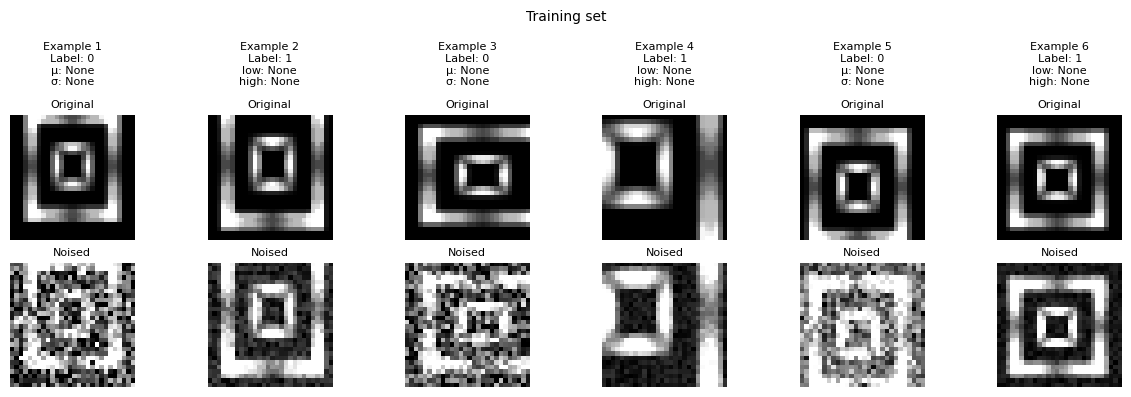

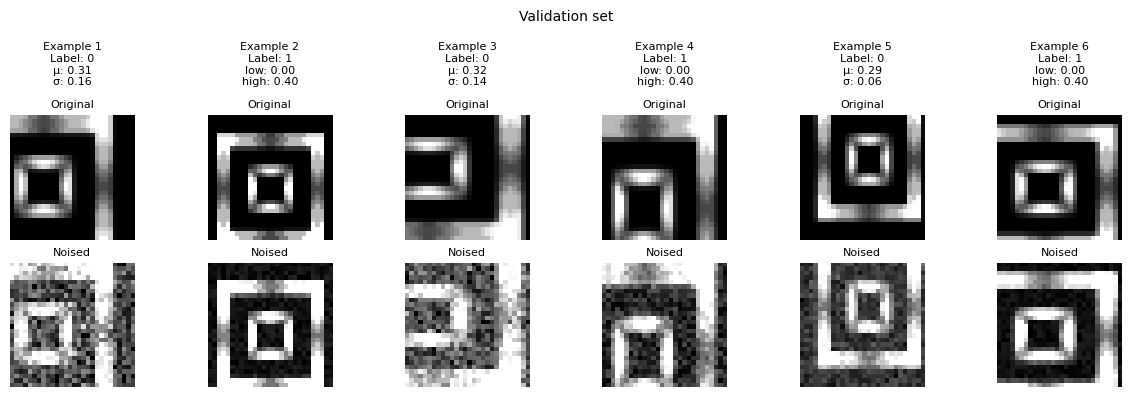

In [188]:
######################### DO NOT MODIFY THIS CELL ##########################

train_ds, val_ds = setup_data(root="./")

if not FINAL_EVALUATION_MODE:
    print("Number of images in training set:", len(train_ds), ", number of images in validation set:", len(val_ds))
    plot_samples(train_ds, num_images=6, title="Training set")
    plot_samples(val_ds, num_images=6, title="Validation set")

## Evaluation Code
Code similar to the one below will be used to evaluate your solution on the test set.

In [189]:
######################### DO NOT MODIFY THIS CELL ##########################
# Cell containing helper functions to compute model metrics

def compute_psnr(input_image: torch.Tensor, target_image: torch.Tensor) -> torch.Tensor:
    """
    Function to calculate PSNR between two images.

    Args:
        input_image (torch.Tensor): First image.
        target_image (torch.Tensor): Second image.

    Returns:
        torch.Tensor: PSNR value.
    """
    mse = F.mse_loss(input_image, target_image)
    if mse == 0:
        return 100
    return 10 * torch.log10(1 / mse)

def model_eval(model: nn.Module, dataloader: DataLoader, device: str = DEVICE) -> Tuple[float, float, float, float]:
    """
    Function to evaluate the model on a dataset.

    Args:
        model (nn.Module): Model to evaluate.
        dataloader (DataLoader): DataLoader with evaluation data.
        device (str, optional): Device on which to perform evaluation.

    Returns:
        tuple: Tuple containing metric values (PSNR, accuracy, MSE for parameter 1, MSE for parameter 2).
    """
    model.eval()
    model.to(device)

    # Initialize variables to store results
    psnr = 0
    correct = 0
    mean_mse = 0
    std_mse = 0

    total_samples = 0
    total_label0_samples = 0

    with torch.no_grad():
        for data in dataloader:
            noised_images = data["noised"].to(device)
            original_images = data["original"].to(device)
            labels = data["label"].to(device)
            params = data["params"].to(device)
            batch_size = len(labels)

            mean_real = params[:, 0].view(-1, 1)
            std_real = params[:, 1].view(-1, 1)

            output_images, labels_pred, mean_pred, std_pred = model(noised_images)

            # Calculate classification accuracy
            correct += ((labels_pred >= 0.5).float().view(-1) == labels).sum().item()

            # Calculate PSNR
            psnr += compute_psnr(output_images, original_images) * batch_size

            # Calculate MSE for parameters when label equals 0
            label0_mask = (labels == 0)
            num_label0 = label0_mask.sum().item()

            if num_label0 > 0:
                mean_mse += F.mse_loss(mean_pred[label0_mask], mean_real[label0_mask], reduction='sum')
                std_mse += F.mse_loss(std_pred[label0_mask], std_real[label0_mask], reduction='sum')

            total_samples += batch_size
            total_label0_samples += num_label0

    # Calculate average metric values
    psnr /= total_samples
    accuracy = correct / total_samples
    mean_mse /= total_label0_samples
    std_mse /= total_label0_samples

    return psnr.item(), accuracy, mean_mse.item(), std_mse.item()


In [190]:
######################### DO NOT MODIFY THIS CELL ##########################
# Cell containing helper functions to score your solution

def calculate_score(
    psnr: float, accuracy: float, mean_mse: float, std_mse: float
) -> Tuple[float, float, float, float]:
    """
    Function to calculate the task points based on model metrics.

    Args:
        psnr (float): PSNR value.
        accuracy (float): Classification accuracy.
        mean_mse (float): MSE for parameter 1.
        std_mse (float): MSE for parameter 2.

    Returns:
        tuple: Tuple containing task points (PSNR, accuracy, MSE for parameter 1, MSE for parameter 2).
    """

    def scale(x, lower=0.0, upper=1.0, max_points=1.0):
        scaled = min(max(x, lower), upper)
        return (scaled - lower) / (upper - lower) * max_points

    accuracy_score = scale(accuracy, lower=0.5, upper=0.95)
    psnr_score = scale(psnr, lower=10.0, upper=16.0)

    mean_score = 0.0
    if mean_mse < 0.005:
        mean_score = 1.0

    std_score = 0.0
    if std_mse < 0.005:
        std_score = 1.0

    return psnr_score, accuracy_score, mean_score, std_score


def grade_solution(model: nn.Module, dataloader: DataLoader) -> float:
    """
    Function to grade the model on the validation dataset.

    Args:
        model (nn.Module): Model to evaluate.
        dataloader (DataLoader): DataLoader with evaluation data.

    Returns:
        float: Number of points awarded for the task.
    """
    psnr, accuracy, mean_mse, std_mse = model_eval(model, dataloader)
    psnr_score, accuracy_score, mean_score, std_score = calculate_score(
        psnr, accuracy, mean_mse, std_mse
    )
    score = round(
        psnr_score * 25 + accuracy_score * 25 + mean_score * 25 + std_score * 25
    )

    # Round to integer, range [0, 100]
    score = round(score)

    print(
        f"Metrics on validation set\n"
        f"psnr: {psnr:.2f}, accuracy: {accuracy:.2f}, mean_mse: {mean_mse:.6f}, std_mse: {std_mse:.6f}\n"
    )
    print(
        f"Partial points for the task\n"
        f"psnr: {(psnr_score * 25):.2f}, accuracy: {(accuracy_score * 25):.2f}, mean_mse: {(mean_score * 25):.2f}, std_mse: {(std_score * 25):.2f}\n"
    )
    print(f"Estimated total points for the task: {score}")
    return score

## Your Solution
You should place your solution in this section only. Make changes exclusively here!

In [317]:
# definitions of augmentations for training and validation datasets. None by default means no augmentations
train_transform = None
val_transform = None

# batch size
BATCH_SIZE: int = 64
LR: float = 1e-3
EPOCHS: int = 30

train_ds, val_ds = setup_data(train_transform, val_transform, root="./")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# create and train your model here

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(negative_slope=0.02),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(negative_slope=0.02),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(negative_slope=0.02),
            nn.MaxPool2d(kernel_size=2),
        )

        self.bottleneck = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(32*3*3, 128)
        )

        self.decoder = nn.Sequential(
            nn.Linear(128, 32*3*3),
            nn.Unflatten(1, (32, 3, 3)),

            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.02),

            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2, bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.02),

            nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2, bias=False),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(0.02),

            nn.Conv2d(4, 1, kernel_size=1, stride=1, padding=0),
            nn.ConvTranspose2d(1, 1, kernel_size=5, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
        )

        self.cls_head = nn.Sequential(
            nn.LeakyReLU(negative_slope=0.02),
            nn.BatchNorm1d(num_features=128),
            nn.Linear(128, 1)
        )

        self.param_head = nn.Sequential(
            nn.LeakyReLU(negative_slope=0.02),
            nn.BatchNorm1d(num_features=128),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        """
        Transformation performed by the model.

        Args:
            x (torch.Tensor): Input image [B, 1, H, W].

        Returns:
            Returned result as a tuple:
            torch.Tensor: Output image [B, 1, H, W].
            torch.Tensor: Classification predictions [B, 1].
            torch.Tensor: Parameter 1 [B, 1].
            torch.Tensor: Parameter 2 [B, 1].
        """

        z = self.encoder(x) # [B, 32, 3, 3]
        features = self.bottleneck(z) # [B, 128]

        denoised = self.decoder(features) # denoised image: [B, 1, 28, 28]

        cls = self.cls_head(features) # is it gaussian or uniform noise? [B, 1]

        mu_raw, s_raw = self.param_head(features).chunk(2, dim=1)  # each is [B,1]
        # clamp s to keep variance reasonable; predict s = log(sigma^2),
        # instead of raw sigma, it's more stable
        s_clamped = torch.clamp(s_raw, min=-10.0, max=10.0)
        var = torch.exp(s_clamped) # sigma^2 > 0
        mu = mu_raw # unconstrained

        if self.training:
          # during training we predict s = log(sigma^2)
          # to stabilize the loss
          sigma_pred = var
        else:
          # for eval we return the true sigma
          sigma_pred = torch.sqrt(var)

        return (
          denoised,
          cls,
          mu,
          sigma_pred
        )

def gaussian_nll(residual, mu, var):
    # r, mu, sigma: [B, N] where N = 28*28
    return 0.5 * (torch.log(2*math.pi*var)
                  + (residual - mu).pow(2) / var).mean()  # mean NLL per pixel

def get_loss(epoch, preds, original, noised, label):
    # [0-5]: cls+denoise; [5-10]: denoise+cls; [10-20]: denoise+params
    if epoch <= 5:
      alpha, beta, gamma = 0.4, 0.6, 0.0
    elif epoch <= 10:
      alpha, beta, gamma = 0.7, 0.3, 0.0
    else:
      alpha, beta, gamma = 0.5, 0.2, 0.3

    denoised, cls, mu, variance = preds

    # 1. reconstruction loss
    denoise_loss = F.mse_loss(denoised, original)

    # 2. classification loss
    cls_loss = F.binary_cross_entropy_with_logits(cls, label)

    # 3. NLL on residuals
    if gamma > 0:
      res = (noised - original).view(original.size(0), -1)
      nll_loss = gaussian_nll(res, mu, variance)
    else:
      nll_loss = 0.0

    loss = alpha * denoise_loss + beta * cls_loss + gamma * nll_loss
    return loss

def train_model() -> Model:
    """Create and train the model"""
    model = Model().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    losses = []

    for epoch in range(EPOCHS):
      model.train()
      running_loss = 0.0
      for batch in tqdm(train_loader):
        original, noised, label = batch["original"].to(DEVICE), batch["noised"].to(DEVICE), batch["label"].to(DEVICE)

        # forward pass
        preds = model(noised)
        loss = get_loss(epoch, preds, original, noised, label.unsqueeze(-1))

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # stats
        loss_value = loss.detach().cpu().item()
        running_loss += loss_value
        losses.append(loss_value)
      scheduler.step()
      print(f"Epoch {epoch}, loss={(running_loss/len(train_loader)):.2f}")

    return model, losses


your_model, losses = train_model()

100%|██████████| 469/469 [00:04<00:00, 99.68it/s]


Epoch 0, loss=0.15


100%|██████████| 469/469 [00:05<00:00, 89.28it/s] 


Epoch 1, loss=0.10


100%|██████████| 469/469 [00:04<00:00, 102.01it/s]


Epoch 2, loss=0.09


100%|██████████| 469/469 [00:05<00:00, 92.72it/s]


Epoch 3, loss=0.08


100%|██████████| 469/469 [00:04<00:00, 95.72it/s] 


Epoch 4, loss=0.08


100%|██████████| 469/469 [00:04<00:00, 101.96it/s]


Epoch 5, loss=0.07


100%|██████████| 469/469 [00:05<00:00, 88.81it/s]


Epoch 6, loss=0.05


100%|██████████| 469/469 [00:04<00:00, 102.48it/s]


Epoch 7, loss=0.05


100%|██████████| 469/469 [00:04<00:00, 94.25it/s]


Epoch 8, loss=0.05


100%|██████████| 469/469 [00:04<00:00, 97.57it/s] 


Epoch 9, loss=0.05


100%|██████████| 469/469 [00:04<00:00, 102.93it/s]


Epoch 10, loss=0.05


100%|██████████| 469/469 [00:05<00:00, 83.53it/s]


Epoch 11, loss=0.16


100%|██████████| 469/469 [00:04<00:00, 93.81it/s]


Epoch 12, loss=-0.14


100%|██████████| 469/469 [00:05<00:00, 83.70it/s]


Epoch 13, loss=-0.15


100%|██████████| 469/469 [00:05<00:00, 92.76it/s]


Epoch 14, loss=-0.16


100%|██████████| 469/469 [00:05<00:00, 89.26it/s]


Epoch 15, loss=-0.16


100%|██████████| 469/469 [00:05<00:00, 84.72it/s]


Epoch 16, loss=-0.16


100%|██████████| 469/469 [00:05<00:00, 93.79it/s]


Epoch 17, loss=-0.16


100%|██████████| 469/469 [00:05<00:00, 81.77it/s]


Epoch 18, loss=-0.16


100%|██████████| 469/469 [00:05<00:00, 91.60it/s]


Epoch 19, loss=-0.16


100%|██████████| 469/469 [00:05<00:00, 81.68it/s]


Epoch 20, loss=-0.16


100%|██████████| 469/469 [00:05<00:00, 91.80it/s]


Epoch 21, loss=-0.16


100%|██████████| 469/469 [00:05<00:00, 84.44it/s]


Epoch 22, loss=-0.16


100%|██████████| 469/469 [00:05<00:00, 88.57it/s]


Epoch 23, loss=-0.16


100%|██████████| 469/469 [00:05<00:00, 92.43it/s]


Epoch 24, loss=-0.16


100%|██████████| 469/469 [00:05<00:00, 82.85it/s]


Epoch 25, loss=-0.16


100%|██████████| 469/469 [00:05<00:00, 93.05it/s]


Epoch 26, loss=-0.17


100%|██████████| 469/469 [00:05<00:00, 81.69it/s]


Epoch 27, loss=-0.16


100%|██████████| 469/469 [00:05<00:00, 92.82it/s]


Epoch 28, loss=-0.16


100%|██████████| 469/469 [00:05<00:00, 82.95it/s]

Epoch 29, loss=-0.16


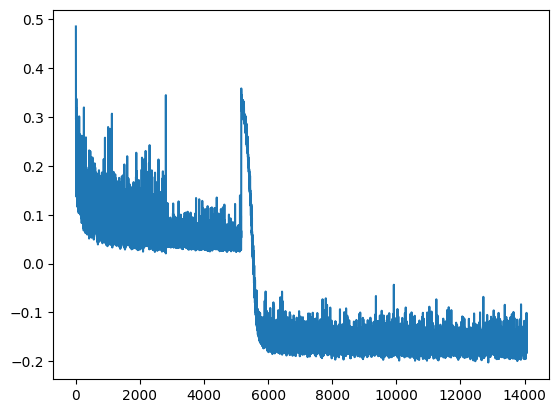

In [319]:
plt.plot(losses)

In [320]:
your_model.eval()
#x = torch.randn((4, 1, 28, 28), device=DEVICE)
x = train_ds[0]["noised"].to(DEVICE).unsqueeze(0)
y = train_ds[0]["original"].to(DEVICE).unsqueeze(0)

pred = your_model(x)

[p.shape for p in pred]

[torch.Size([1, 1, 28, 28]),
 torch.Size([1, 1]),
 torch.Size([1, 1]),
 torch.Size([1, 1])]

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

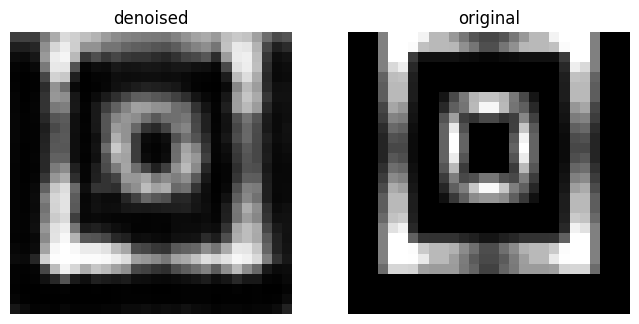

In [321]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(pred[0][0].detach().cpu().permute(1, 2, 0), cmap='gray')
axes[0].set_title("denoised")
axes[0].axis('off')

axes[1].imshow(y[0].detach().cpu().permute(1, 2, 0), cmap='gray')
axes[1].set_title("original")
axes[1].axis('off')

## Evaluation
Running the cell below will allow you to check how many points your solution would score on the validation data. Before submitting, make sure the entire notebook runs from start to finish without errors and without any user intervention after choosing "Run All".

Metrics on validation set
psnr: 16.26, accuracy: 0.98, mean_mse: 0.001780, std_mse: 0.001089

Partial points for the task
psnr: 25.00, accuracy: 25.00, mean_mse: 25.00, std_mse: 25.00

Estimated total points for the task: 100


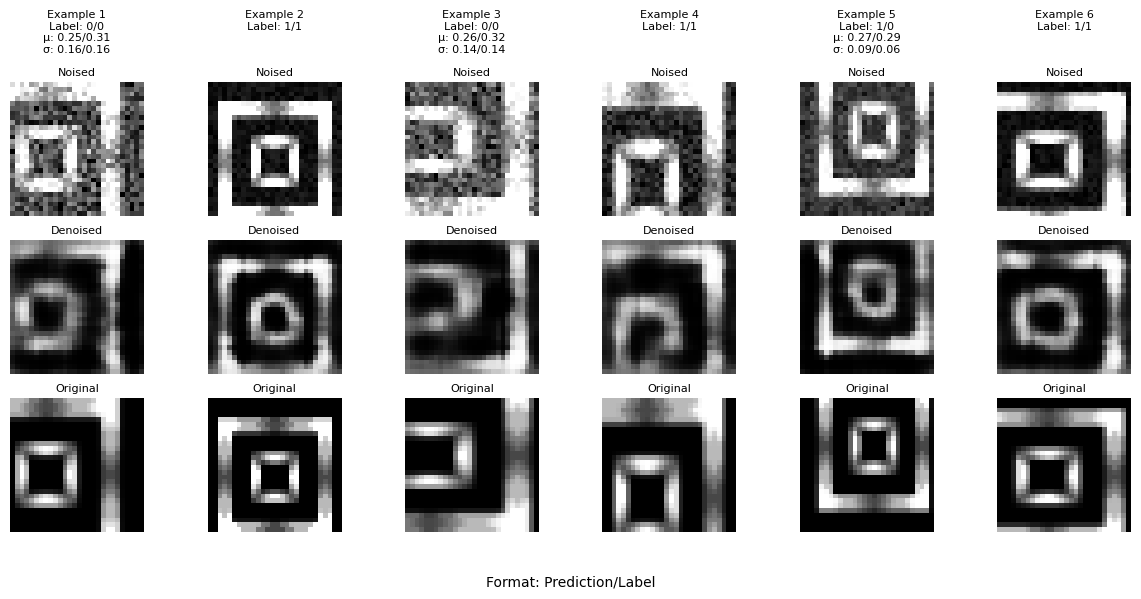

In [322]:
######################### DO NOT MODIFY THIS CELL ##########################

val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

if not FINAL_EVALUATION_MODE:
    grade_solution(your_model, val_dataloader)
    examples = next(iter(val_dataloader))
    plot_results(your_model, examples, num_images=6)

During evaluation, the model will be saved as `your_model.pkl` and assessed on the test set.

In [197]:
######################### DO NOT MODIFY THIS CELL ##########################

if FINAL_EVALUATION_MODE:
    import cloudpickle

    # Gdy model posiada parametry, ustaw go w trybie ewaluacji i przenieś na CPU
    if list(your_model.parameters()):
        your_model.eval()
        your_model.cpu()

    OUTPUT_PATH = "file_output"
    FUNCTION_FILENAME = "your_model.pkl"
    FUNCTION_OUTPUT_PATH = os.path.join(OUTPUT_PATH, FUNCTION_FILENAME)

    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

    with open(FUNCTION_OUTPUT_PATH, "wb") as f:
        cloudpickle.dump(your_model, f)